---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 2

---

Please write your full name here
- **Name** : "amr mohamed ali"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from d2l import tensorflow as d2l
import pandas as pd
import math

# Part 1 Computational Graphs

**Motivation**. In this section we will develop expertise with an intuitive understanding of **backpropagation**, which is a way of computing gradients of expressions through recursive application of **chain rule**.

Considering the example of a simple perceptron defined by just one dense layer: $ y = \sigma(Wx + b)$, where $W$ represents a matrix of weights, $b$ is a bias, $x$ is the input, $\sigma$ is the sigmoid activation function, and $y$ is the output. We can visualize this operation using a graph: 

![alt text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab1/img/computation-graph-2.png)


## Example
Suppose that we have a function of the form:

$$
f(x,y) = \frac{x + \sigma(y)}{\sigma(x) + (x+y)^2}
$$

It is very important to stress that if you were to launch into performing the differentiation with respect to either \\(x\\) or \\(y\\), you would end up with very large and complex expressions. However, doing so is completely unnecessary because we don't need to have an explicit function written down that evaluates the gradient. We only have to know how to compute it.

![Circ1](./img/circ1.svg)



1. **Compute the forward path for this function. Use intermediate variables as shown above**

- f --> final output
- You can use math.exp for sigmoid calculation

In [2]:
x = 3 # example values
y = -4

# forward pass

### START CODE HERE ### (≈ 8 lines of code)
sigy = math.exp(y)
num = sigy + x
sigx = math.exp(x)
xpy = x + y
xpysqr = xpy ** 2
den = sigx + xpysqr
invden = 1 / den
f = num * invden # i think it should be * not \ as in the computational graph 
### END CODE HERE ###

In [3]:
print ('f = %f '%(f))

f = 0.143146 


Computing the backprop pass is easy: We’ll go backwards and for every variable along the way in the forward pass `sigy, num, sigx, xpy, xpysqr, den, invden` we will have the same variable, but one that begins with a `d`, which will hold the gradient of the output of the expresion with respect to that variable. Additionally, note that every single piece in our backprop will involve computing the local gradient of that expression, and chaining it with the gradient on that expression with a multiplication. 


2. **Compute the backward path for this function to get:**
$$
\nabla f(x,y) = [ \frac{\partial f}{\partial y}, \frac{\partial f}{\partial x} ]
$$

- **Use intermediate variables**
- **Print dy and dx**
- *Hint: Gradients add up at forks. The forward expression involves the variables x,y multiple times, so when we perform backpropagation we must be careful to use += instead of = to accumulate the gradient on these variables (otherwise we would overwrite it). This follows the multivariable chain rule in Calculus, which states that if a variable branches out to different parts, then the gradients that flow back to it will add.*

In [4]:
### START CODE HERE ### (≈ 12 lines of code)
dx = 0
dy = 0
df_dnum = invden
dnum_dx = 1
dx += df_dnum * dnum_dx
df_dinvden = num
dinvden_dden = -1 / (den **2)
dden_dsigx = 1
dsigx_dx = sigx
dx += df_dinvden * dinvden_dden * dden_dsigx * dsigx_dx
dnum_dsigy = 1
dsigy_dy = sigy
dy += dnum_dsigy * dsigy_dy
dden_dxpysqr = 1
dxpysqr_dxpy = 2 * xpy
dxpy_dy = 1
dy += df_dinvden * dinvden_dden * dden_dxpysqr * dxpysqr_dxpy * dxpy_dy
### END CODE HERE ###

In [5]:
print ('df/dx = ' + (str(dx)))
print ('df/dy = ' + (str(dy)))

df/dx = -0.08893154540100023
df/dy = 0.03189331113120729


# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**

When our inputs consist of $d$ features,
we express our prediction $\hat{y}$ (in general the "hat" symbol denotes estimates) as

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

Determines a measure of *fitness*.
The *loss function* quantifies the distance
between the *real* and *predicted* value of the target.
The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case
as shown:

![Fit data with a linear model.](./img/fit-linreg.svg)

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing nearly any deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will often settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [6]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [7]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [8]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


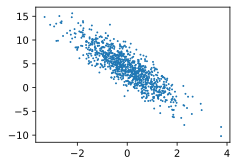

In [9]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not**

In [10]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a TensorFlow data iterator."""
    #### START YOUR CODE HERE ### ~ 4 LINES OF CODE
    
    # Read data
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    # check on flag to shuffle or not
    if is_train:
        # shuffle dataset
        dataset.shuffle(len(data_arrays[0]))
        
    # Batch dataset
    dataset = dataset.batch(batch_size)
    
    ### END CODE HERE ###
    return dataset

In [11]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [12]:
### START YOUR CODE HERE ### ~ 1 LINE OF CODE
print(next(iter(data_iter)))
### END CODE HERE ###

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.18030666, -0.95028627],
       [-0.03964049, -0.7425406 ],
       [ 1.3231523 , -0.61854804],
       [ 0.8540664 , -0.08899953],
       [ 2.4488697 ,  0.762508  ],
       [ 1.2659615 ,  0.9801489 ],
       [ 1.5293121 , -0.57500345],
       [ 0.8987044 , -1.250801  ],
       [-0.8604956 ,  1.260746  ],
       [-0.6830498 ,  0.02615766]], dtype=float32)>, <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 7.0726256],
       [ 6.653464 ],
       [ 8.956834 ],
       [ 6.2184806],
       [ 6.512457 ],
       [ 3.4136338],
       [ 9.212745 ],
       [10.263597 ],
       [-1.8177388],
       [ 2.7450585]], dtype=float32)>)


4. **Explain what the output shape in the prvious tensors means:**


**Answer:** number of rows is 10 because we choosed the batch size as 10 and 2 columns for the 2 features 

5. **How many batches are in the data_iter ?**

**Answer:** number of batches is equal to the total number of examples in the dataset divided by the batch size rounding the result up for the Ones place = 1000 / 10 = 100 batch

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [13]:
## START YOUR CODE HERE ## ~ 2 lines of code
w = tf.random.normal((features.shape[1],1),mean=0,stddev=0.01)
b = tf.random.normal((1,1),mean=0,stddev=0.01)
### END CODE HERE ###

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [14]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    ## START YOUR CODE HERE ## ~ 1 line of code
    result = tf.add(tf.matmul(X,w),b)
    ### END CODE HERE ###
    return result

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [39]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    ## START YOUR CODE HERE ## ~ 1 line of code
    loss = (tf.subtract(y_hat,tf.reshape(y,y_hat.shape)) ** 2 ) / 2
    ### END CODE HERE ###
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

Note: use assign_sub


In [40]:
def sgd(params, grads, lr, batch_size):  # @save
    """Minibatch stochastic gradient descent."""

    # START YOUR CODE HERE ## ~ 2 lines of code
    for param, grad in zip(params, grads):
        param.assign_sub((lr * grad) / batch_size)
    ### END CODE HERE ###


### Training

10. **Implement the following loop**

* For each epoch :
    * Initialize parameters $(\mathbf{w}, b)$
    * Repeat until done
        * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
    * Print the loss at the end of each epoch using: `print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')`

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.


Set the number of epochs `num_epochs` and the learning rate `lr` to 3 and 0.03, respectively.

In [72]:
lr = 0.03
num_epochs = 3 # if you increased the number of epochs the error precentage will decrease
net = linreg
loss = squared_loss
batch_size = 10 # i added the batch size

In [73]:
# START YOUR CODE HERE ## ~ 8 lines of code
w = tf.Variable(tf.random.normal(shape=(features.shape[1], 1), mean=0, stddev=0.01))
b = tf.Variable(tf.random.normal(shape=(1, 1), mean=0, stddev=0.01))
for epoch in range(num_epochs):
    for X, y in data_iter:
        with tf.GradientTape() as g:
            l = tf.math.reduce_mean(loss(net(X,w,b), y))
        dw, db = g.gradient(l, [w, b])
        sgd([w, b], [dw, db], lr, batch_size)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(l)):f}')
### END CODE HERE ###


epoch 1, loss 11.450834
epoch 2, loss 6.514688
epoch 3, loss 3.710009


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned**] through our training loop. They should turn out to be very close to each other.


In [71]:
## YOUR CODE HERE ##
print(f'error in estimating w: {tf.math.reduce_mean(tf.abs((true_w - tf.reshape(w,true_w.shape)) / true_w) * 100)}')
print(f'error in estimating b: {((true_b - b) / true_b)[0][0] * 100}')

error in estimating w: 1.8869609832763672
error in estimating b: 1.2935911417007446


## Boston Housing Price Dataset

In this section, we’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time, such as the
crime rate, the local property tax rate, and so on. The dataset has few data points: only
506, split between 404 training samples and 102 test samples. 

### Loading the Dataset

1. **Load the Boston housing dataset from tf.keras.datasets into 2 tuples: (train_data, train_targets), (test_data, test_targets)**

In [ ]:
## START YOUR CODE HERE ## ~ 2 lines of code


### END CODE HERE ###

2. **Look at the test and train data. Print their shapes**

In [ ]:
### START CODE HERE ### (≈ 4 lines of code)

### END CODE HERE ###

print ('The shape of train_data is: ' + str(shape_X))
print ('The shape of train_targets is: ' + str(shape_Y))
print ('I have f = %d features!' % (f))
print ('I have m = %d training examples!' % (m))

3. **Search for the dataset features and write their names and information about each column:**

**Answer**:


4. **Convert the train_data and the train_targets to pandas dataframes.**
    * Use the 'columns' attribute so that the output dataframes have the column names you found in question 3

In [ ]:
### START CODE HERE ### (≈ 4 lines of code)

### END CODE HERE ###

In [ ]:
features_df.head()

In [ ]:
targets_df.head()

5. **What are the ranges of each column in features and the target column?**
    * Use .describe method to find the answer

In [ ]:
features_df.info()

In [ ]:
### Code for Features ### (≈ 1 line of code)


In [ ]:
### Code for Target ### (≈ 1 line of code)


### Preparing the data

As you noticed from the previous exercise each feature in the
input data (for example, the crime rate) has a different scale. For instance, some values
are proportions, which take values between 0 and 1, others take values between 1
and 12, others between 0 and 100, and so on.

It would be problematic to feed into a neural network values that all take wildly different
ranges. A widespread best practice
for dealing with such data is to do:

- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.

6. **Use feature-wise normalization to normalize the data**

Hint: Avoid leak between train and test data !!

In [ ]:
### START CODE HERE ### (≈ 6 lines of code)

### END CODE HERE ###

### Building your model

Because so few samples are available, we’ll use a very small model with two intermediate
layers, each with 64 units.

7. **Use tf.keras.Sequential to build a model with:**
    - 2 hidden layers each having 64 neurons and relu activation.
    - 1 output layer
    
Hint: For output layer remember that this is a regression model

In [ ]:
def build_model():
    ### START CODE HERE ### (≈ 1 line of code)

    
    ### END CODE HERE ###
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

### Validating your approach using K-fold validation

To evaluate our model while we keep adjusting its parameters (such as the number of
epochs used for training), we could split the data into a training set and a validation
set. But because we have so few data points, the
validation set would end up being very small (for instance, about 100 examples). As a
consequence, the validation scores might change a lot depending on which data
points we chose for validation and which we chose for training: the validation scores
might have a high variance with regard to the validation split. This would prevent us
from reliably evaluating our model.
The best practice in such situations is to use K-fold cross-validation (see below figure).

![grayscale](https://deepchecks.com/wp-content/uploads/2022/01/evaluating_model_img9-1024x557.png)

8. **Use model.fit to train the partial training data and validate validation data (val_data, val_targets) with num_epochs, and batch_sz**

- Complete the k_fold_validation function

In [ ]:
def k_fold_validation(train_data, train_targets, k = 4, num_epochs = 40, batch_sz = 16):
    
    num_val_samples = len(train_data) // k
    all_mae_histories = []

    for i in range(k):
        print(f"Processing fold #{i}")

        # Prepares the validation data: data from partition #k
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # Prepares the training data: data from all other partitions
        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        # Builds the Keras model (already compiled)
        model = build_model()


        ### START CODE HERE ### (≈ 1 line of code)
        
        
        ### END CODE HERE ###

        mae_history = history.history["val_mae"]
        all_mae_histories.append(mae_history)
    return all_mae_histories

In [ ]:
num_epochs = 40
batch_sz = 16
all_mae_histories = k_fold_validation(train_data = train_data, train_targets = train_targets, k = 4, num_epochs = num_epochs, batch_sz = batch_sz)

The 'all_mae_histories' carries for each fold the mae for each epoch of 500 epochs:

In [ ]:
np.array(all_mae_histories).shape

**Building the history of successive mean K-fold validation scores**

We can then compute the average of the per-epoch MAE scores for all folds.

So the output here would be the average mae for each epoch of training across different data splits

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores, excluding the first 10 data points**

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE
for the first few epochs is dramatically higher than the values that follow. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve.

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

### Hyperparameter Tuning

#### Epochs
Let's try training for longer maybe we would get a better output

9. **Use the function from question 8 and try training for 500 epochs, then plot MAE vs 500 epochs**

In [ ]:
### START CODE HERE ### (≈ 3 or 1 lines of code)

### END CODE HERE ###

The 'all_mae_histories' carries for each fold the mae for each epoch of 500 epochs:

In [ ]:
np.array(all_mae_histories).shape

**Building the history of successive mean K-fold validation scores**

We can then compute the average of the per-epoch MAE scores for all folds.

So the output here would be the average mae for each epoch of training across different data splits

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores, excluding the first 10 data points**

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE
for the first few epochs is dramatically higher than the values that follow. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve.

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

10. **What epoch size would you pick? Why?**

- Hint: When do we start overfitting?
- Note: We truncate the first 10 epochs!!

**Answer:**

As you can see in above, validation MAE stops improving significantly after
120–140 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.

#### Batch size

##### Size =  4

10. **Use the function from question 8 and try training for 4 batch size using best number of epochs**

In [ ]:
### START CODE HERE ### (≈ 3 or 1 lines of code)

### END CODE HERE ###

In [ ]:
np.array(all_mae_histories).shape

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

##### Size =  16

11. **Use the function from question 8 and try training for 16 batch size using best number of epochs**

In [ ]:
### START CODE HERE ### (≈ 3 or 1 lines of code)


### END CODE HERE ###

In [ ]:
np.array(all_mae_histories).shape

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.grid()
plt.show()

##### Size =  64

12. **Use the function from question 8 and try training for 64 batch size using best number of epochs**

In [ ]:
### START CODE HERE ### (≈ 3 or 1 lines of code)

### END CODE HERE ###

In [ ]:
np.array(all_mae_histories).shape

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10, 10)

truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.yticks(np.arange(2,np.max(truncated_mae_history),.2))
plt.grid()
plt.show()

10. **What effect does changing epoch size have on learning? Choose a batch size and the reason for your choice**

**Answer:**



### Training the final model

Once you’re finished tuning other parameters of the model (in addition to the
number of epochs), you can
train a final production model on all of the training data, with the best parameters,
and then look at its performance on the test data.

14. **Build and Train a final model on the entire training data then evaluate it on the test data**

In [ ]:
######### Your code
best_batch = ##########
best_epoch = #########

In [ ]:
### START CODE HERE ### (~ 3 lines of code)

## Build model

## Train model

## Evaluate model on test data


### END CODE HERE ###

In [ ]:
test_mae_score

15. **Interpret the test_mae_score. How many thousands of dollars are we off by?**


**Answer:** 

**Optional**:

Change the number of layers in the model and output the resulting learning curves.